# This notebook demonstrates the application of Prescriptive Analytics - Causal Model using EconML and DoubleML

* EconML is part of Microsoft ALICE Project: https://www.microsoft.com/en-us/research/group/alice/

* And DoubleML: https://docs.doubleml.org/stable/index.html

## In addition, we will also use:

* SHAP algorithm to determine the magnitude and direction of influence
* Many Machine Learning algorithms to find the magnitude and direction of causal factors

# There are four types of data analytics:

##1. Descriptive: answers questions about “what happened?”
* These can be answered with statistics, data visualisations and interpretations


##2. Diagnostic: “why did this happen?”
* We won't treat this separately but we will look at it from the standpoint of descriptive, predictive and prescriptive

##3. Predictive: “what is going to happen in the future?” [forecasting & prediction]
* This will help us determine the data  (data variables, features, columns) that influences outcomes
* At times this approach will not identify causal factors, instead these variables may be correlated
* Features Importances - rank these in order of influence on the outcomes e.g., if we discover that certain data columns have minimal importance, the idea is that we can remove these from the "model".

##4. Prescriptive: “what actions should be taken next?”
* This is to identify causal factors

##All four types are often used together to create a complete story of based on data (data storytelling).

## Importantly, we want to combine both Predictive and Prescriptive approaches since Predictive will identify correlated features and Prescriptive will identify casual factors - together we will have identified all relevant data to create a complete "model"  (data plus machine learning algorithms).

#Terminology:

* Confounders (covariates): a confounding variable is an unmeasured variable that influences both the supposed cause and effect.

* Treatment variable: also called the independent variable (the one you think might be the cause) and then measure the dependent variable (the one you think might be the effect) to find out what this effect might be.


* Instrument variable: An instrumental variable is a third variable, Z, used in regression analysis when you have endogenous variables — variables that are influenced by other variables in the model. In other words, you use it to account for unexpected behavior between variables. Using an instrumental variable to identify the hidden (unobserved) correlation allows you to see the true correlation between the explanatory variable and response variable, Y [https://www.statisticshowto.com/instrumental-variable/]

# Business Problem - Housing Affordability and Prices
## Does Race cause a decline in house prices?

## Sections:

##1. A Gentle Start: Linear Regression
##2. Train a Fine-tuned Predictive ML Model
##3. Correlation Interpretation
* Feature Importance -- Learn the top predictors for a given ML model
* Partial Dependence Plot -- Learn the statistical relationship between share of Black residents and housing price

##4. Causal Interpretation
* Direct Causal Effect -- Do the top predictors also have a direct effect on outcome of interest?

* Segmentation -- How different type of houses respond differently to number of rooms?

* What If Analysis -- How the overall housing price changes with one more room?
* Policy Analysis -- What is the best policy considering cost?
* Cohort Analysis -- What is the causal effect on a new dataset?

## Data Dictionary

* CRIM	per capita crime rate by town
* ZN	proportion of residential land zoned for lots over 25,000 sq.ft.
* INDUS	proportion of non-retail business acres per town.
* CHAS	Charles River dummy variable (1 if tract bounds river; 0 otherwise)
* NOX	nitric oxides concentration (parts per 10 million)
* RM	average number of rooms per dwelling
* AGE	proportion of owner-occupied units built prior to 1940
* DIS	weighted distances to five Boston employment centres
* RAD	index of accessibility to radial highways
* TAX	full-value property-tax rate per $10,000
* PTRATIO	pupil-teacher ratio by town
* B	is the proportion of Black residents by town
* LSTAT	lower socioeconomic status by town: (share of adults with less than high school education + share of male workers classified as laborers)

* MEDV	Median value of owner-occupied homes in $1000's

## Install and import python libraries as well as create settings

In [ ]:
%pip install econml

In [ ]:
%pip install lightgbm

In [ ]:
import econml

from econml.orf import DMLOrthoForest, DROrthoForest
from econml.dml import CausalForestDML
from econml.sklearn_extensions.linear_model import WeightedLassoCVWrapper, WeightedLasso, WeightedLassoCV

In [ ]:
# core python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [ ]:
# view charts inline
%matplotlib inline

In [ ]:
# machine learning
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
# shap algorithm
import shap

## Load dataset

In [ ]:
from sklearn.datasets import fetch_openml

boston_data = fetch_openml(data_id=531)
boston_data

The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.


{'data':         CRIM    ZN  INDUS CHAS    NOX     RM   AGE     DIS RAD    TAX  \
 0    0.00632  18.0   2.31    0  0.538  6.575  65.2  4.0900   1  296.0   
 1    0.02731   0.0   7.07    0  0.469  6.421  78.9  4.9671   2  242.0   
 2    0.02729   0.0   7.07    0  0.469  7.185  61.1  4.9671   2  242.0   
 3    0.03237   0.0   2.18    0  0.458  6.998  45.8  6.0622   3  222.0   
 4    0.06905   0.0   2.18    0  0.458  7.147  54.2  6.0622   3  222.0   
 ..       ...   ...    ...  ...    ...    ...   ...     ...  ..    ...   
 501  0.06263   0.0  11.93    0  0.573  6.593  69.1  2.4786   1  273.0   
 502  0.04527   0.0  11.93    0  0.573  6.120  76.7  2.2875   1  273.0   
 503  0.06076   0.0  11.93    0  0.573  6.976  91.0  2.1675   1  273.0   
 504  0.10959   0.0  11.93    0  0.573  6.794  89.3  2.3889   1  273.0   
 505  0.04741   0.0  11.93    0  0.573  6.030  80.8  2.5050   1  273.0   
 
      PTRATIO       B  LSTAT  
 0       15.3  396.90   4.98  
 1       17.8  396.90   9.14  
 2       

In [ ]:
# data columns or features
boston_data.feature_names

['CRIM',
 'ZN',
 'INDUS',
 'CHAS',
 'NOX',
 'RM',
 'AGE',
 'DIS',
 'RAD',
 'TAX',
 'PTRATIO',
 'B',
 'LSTAT']

In [ ]:
# data for each column
boston_data.data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48


In [ ]:
boston_data.data.shape

(506, 13)

In [ ]:
# the house prices - what we are trying to  predict
# oftten called the outcome or independent variable
boston_data.target

,MEDV
0,24.0
1,21.6
2,34.7
3,33.4
4,36.2
...,...
501,22.4
502,20.6
503,23.9
504,22.0


## Linear Regression

In [ ]:
# add a constant column - we want to find the equation and intercept
X = sm.add_constant(boston_data.data)

In [ ]:
X

,const,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,1.0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98
1,1.0,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14
2,1.0,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03
3,1.0,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94
4,1.0,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,1.0,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67
502,1.0,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08
503,1.0,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64
504,1.0,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48


In [ ]:
X.dtypes

,0
const,float64
CRIM,float64
ZN,float64
INDUS,float64
CHAS,category
NOX,float64
RM,float64
AGE,float64
DIS,float64
RAD,category


In [ ]:
# Convert dataframe types
X_df = X.astype('float64')

#  rename column
X_df = X_df.rename(columns={"const": "Intercept"})

In [ ]:
X_df

,Intercept,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,1.0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,1.0,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,1.0,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,1.0,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,1.0,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,1.0,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,1.0,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,1.0,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,1.0,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


## Construct the model with linear regression

In [ ]:
my_linear_regression =  sm.OLS(boston_data.target, X_df)

In [ ]:
model = sm.OLS(boston_data.target, X_df)

In [ ]:
model.__dict__

{'weights': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
 

## Train ML

In [ ]:
results = model.fit()

In [ ]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Thu, 08 Aug 2024   Prob (F-statistic):          6.72e-135
Time:                        08:31:02   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36.4595      5.103      7.144      0.000      26.432      46.487
CRIM          -0.1080      0.033     -3.287      0.001      -0.173      -0.043
ZN             0.0464      0.014      3.382      0.001       0.019       0.073
INDUS          0.0206      0.061      0.334      0.738      -0.100       0.141
CHAS           2.6867      0.862      3.118      0.002       0.994       4.380
NOX          -17.7666      3.820     -4.651      0.000     -25.272     -10.262
RM             3.8099      0.418      9.116      0.000       2.989       4.631
AGE            0.0007      0.013      0.052      0.958      -0.025       0.027
DIS           -1.4756      0.199     -7.398      0.000      -1.867      -1.084
RAD            0.3060      0.066      4.613      0.000       0.176       0.436
TAX           -0.0123      0.004     -3.280      0.001      -0.020      -0.005
PTRATIO       -0.9527      0.131     -7.283      0.000      -1.210      -0.696
B              0.0093      0.003      3.467      0.001       0.004       0.015
LSTAT         -0.5248      0.051    -10.347      0.000      -0.624      -0.425
==============================================================================
Omnibus:                      178.041   Durbin-Watson:                   1.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              783.126
Skew:                           1.521   Prob(JB):                    8.84e-171
Kurtosis:                       8.281   Cond. No.                     1.51e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Interpretation: adjusted R-squared is the proportion of the outcome/target variable explained by the the features/predictors

## Predictive ML model

### split data into training (80%) and testing (20%)

In [ ]:
# Split data into train and test
from sklearn.model_selection import train_test_split

# drop intercept column (not needed)
X_df = X_df.drop(columns=["Intercept"])

x_train, x_test, y_train, y_test = train_test_split(
    X_df, boston_data.target, test_size=0.2, random_state=0
)

In [ ]:
categorical = ["CHAS"]
# Store the numerical columns in a list numerical
numerical = list(set(boston_data.feature_names).difference(set(categorical)))

In [ ]:
numerical

['DIS',
 'PTRATIO',
 'TAX',
 'RAD',
 'NOX',
 'RM',
 'INDUS',
 'CRIM',
 'AGE',
 'LSTAT',
 'B',
 'ZN']

## create the model

In [ ]:
# train a lightGBM regression model
ml_model = LGBMRegressor()

In [ ]:
# establish the search paramters
param_grid = {"learning_rate": [0.1, 0.05, 0.01], "max_depth": [3, 5, 10]}

### Grid Search: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [ ]:
# use grid searrch
search = GridSearchCV(ml_model, param_grid, n_jobs=-1)

In [ ]:
# now train  ML
search.fit(x_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1029
[LightGBM] [Info] Number of data points in the train set: 404, number of used features: 13
[LightGBM] [Info] Start training from score 22.611881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

GridSearchCV(estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.05, 0.01],
                         'max_depth': [3, 5, 10]})

In [ ]:
print("Best estimator: ", search.best_params_)

Best estimator:  {'learning_rate': 0.1, 'max_depth': 10}


## Accuracy - use test data

In [ ]:
print("Test set score: ", search.best_estimator_.score(x_test, y_test))

Test set score:  0.7025992540638362


#  Correlation Interpretation
## SHAP algorithm: https://shap.readthedocs.io/en/latest/index.html


In [ ]:
fitted_model = search.best_estimator_

In [ ]:
# use interventional approach
background = shap.maskers.Independent(x_train, max_samples=1000)

In [ ]:
background.__dict__

{'output_dataframe': True,
 'feature_names': Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
        'PTRATIO', 'B', 'LSTAT'],
       dtype='object'),
 'data': array([[3.5809e-01, 0.0000e+00, 6.2000e+00, ..., 1.7400e+01, 3.9170e+02,
         9.7100e+00],
        [1.5876e-01, 0.0000e+00, 1.0810e+01, ..., 1.9200e+01, 3.7694e+02,
         9.8800e+00],
        [1.1329e-01, 3.0000e+01, 4.9300e+00, ..., 1.6600e+01, 3.9125e+02,
         1.1380e+01],
        ...,
        [1.5098e-01, 0.0000e+00, 1.0010e+01, ..., 1.7800e+01, 3.9451e+02,
         1.0300e+01],
        [2.2927e-01, 0.0000e+00, 6.9100e+00, ..., 1.7900e+01, 3.9274e+02,
         1.8800e+01],
        [1.3914e-01, 0.0000e+00, 4.0500e+00, ..., 1.6600e+01, 3.9690e+02,
         1.4690e+01]]),
 'clustering': None,
 'max_samples': 1000,
 '_masked_data': array([[3.5809e-01, 0.0000e+00, 6.2000e+00, ..., 1.7400e+01, 3.9170e+02,
         9.7100e+00],
        [1.5876e-01, 0.0000e+00, 1.0810e+01, ..., 1.9200e+01, 3.

# Explainable Machine Learning (Model understanding) with SHAP

In [ ]:
explainer = shap.TreeExplainer(
    fitted_model, data=background, feature_names=boston_data.feature_names
)

In [ ]:
shap_values = explainer(x_test)

* CRIM	per capita crime rate by town
* ZN	proportion of residential land zoned for lots over 25,000 sq.ft.
* INDUS	proportion of non-retail business acres per town.
* CHAS	Charles River dummy variable (1 if tract bounds river; 0 otherwise)
* NOX	nitric oxides concentration (parts per 10 million)
* RM	average number of rooms per dwelling
* AGE	proportion of owner-occupied units built prior to 1940
* DIS	weighted distances to five Boston employment centres
* RAD	index of accessibility to radial highways
* TAX	full-value property-tax rate per $10,000
* PTRATIO	pupil-teacher ratio by town
* B	is the proportion of Black residents by town
* LSTAT	lower socioeconomic status by town: (share of adults with less than high school education + share of male workers classified as laborers)

* MEDV	Median value of owner-occupied homes in $1000's

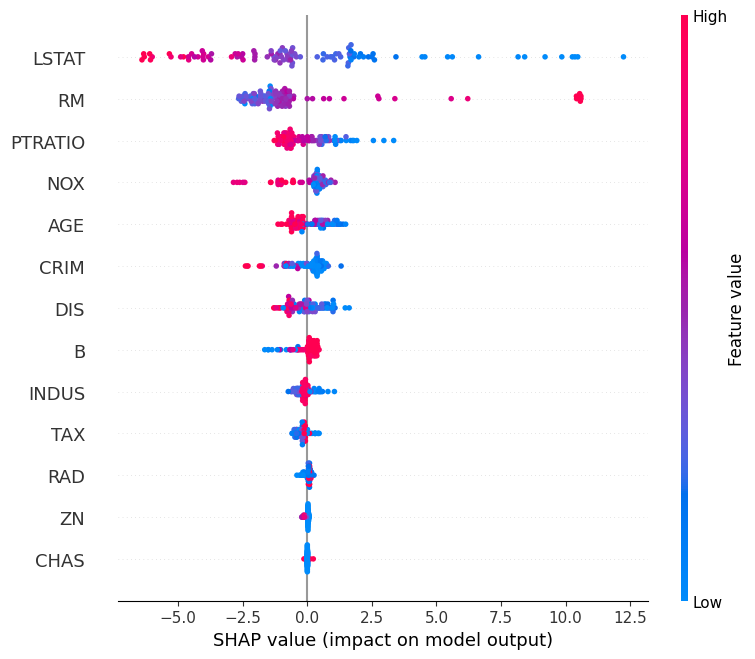

In [ ]:
# plot the feature importance
shap.summary_plot(shap_values, x_test)

###  SHAP show  the most important features sorted by their importance level. It tells us that neighborhoods with a smaller shares of low socioeconomic status residents, higher median number of rooms and less pupil-teacher ratio will have a higher housing price.

###  This in line with what we learnt from Linear Regression above.

SHAP force plots

In [ ]:
shap.initjs()
shap.force_plot(shap_values)

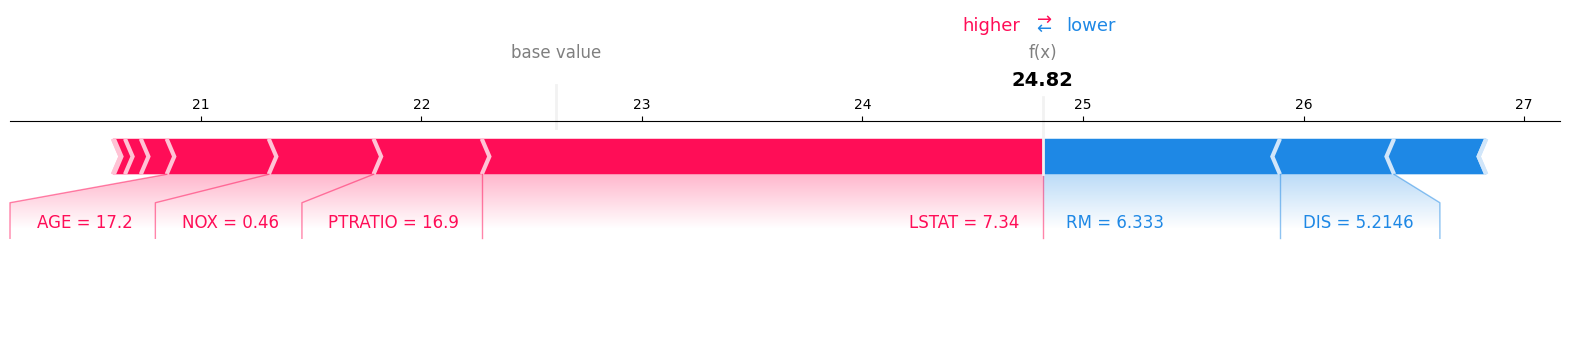

In [ ]:
shap.force_plot(shap_values[0], matplotlib=True)

### Partial Dependence  Plot  - Show statistical relationship between share of Black residents and housing price

The top 5 features by correlation:

AGE, RM, NOX, CRIM, TAX

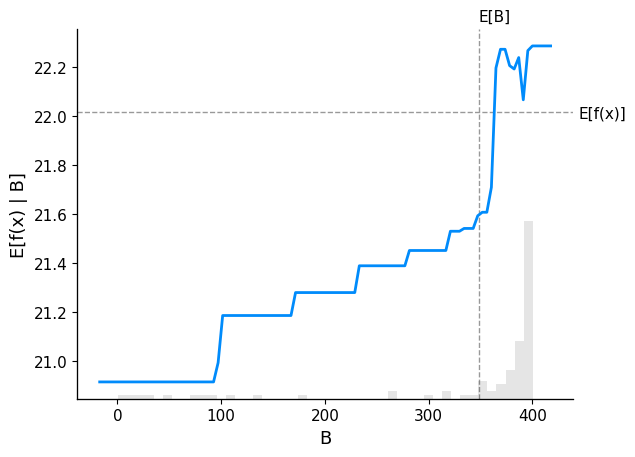

In [ ]:
shap.plots.partial_dependence(
    "B",
    fitted_model.predict,
    pd.DataFrame(x_test, columns=boston_data.feature_names),
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

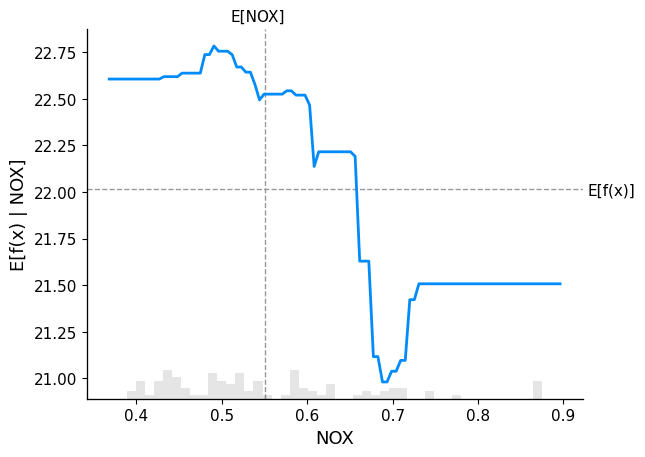

In [ ]:
shap.plots.partial_dependence(
    "NOX",
    fitted_model.predict,
    pd.DataFrame(x_test, columns=boston_data.feature_names),
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

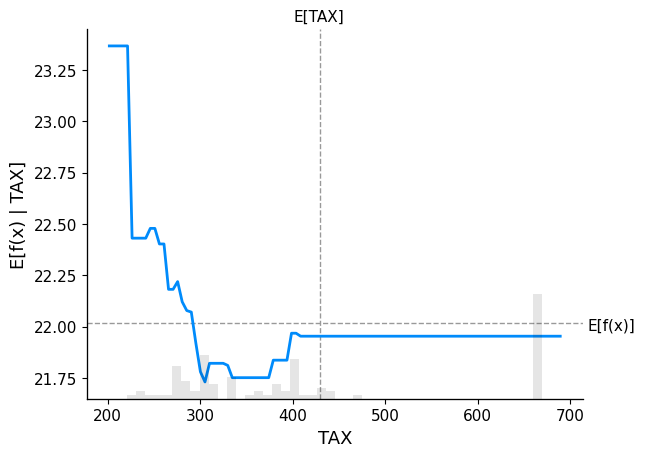

In [ ]:
shap.plots.partial_dependence(
    "TAX",
    fitted_model.predict,
    pd.DataFrame(x_test, columns=boston_data.feature_names),
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

### Interpretations: Taking share of Black residents as an example, here B is a function of Black population in town, the higher of B, the lower of Black population(%). From the coefficient of linear regression, the shap summary plot and also the partial dependence plot, we could get the same conclusion that there is a positive correlation between B and median housing price. In other word, housing price will decrease with the increasing of Black population(%). However, is that really causal? Let us validate that in the following section.

Note, this relationship is not linear. B = 1000(Bk - 0.63)^2 where Bk is the proportion. Hence a high value of B means low level of black population, however a high level of black population is a medium value.

###  Overall, all the insights above are coming from corelation perspective, telling us the positive or negative correlation between each predictor and the target.

### To correctly find the causal relationship, we have to train a different model controlling on all the possible hidden variables (confounders) and learn the direct causal effect for a given feature.

### That's what the causal interpretation tool is doing. In the following section, we will explore the causal relationship in different ways.

# Causal Interpretation
### Business question: Direct Causal Effect -- Do the top predictors also have a direct effect on outcome of interest?

In [ ]:
classification = False

In [ ]:
# order feature names according to shap values
vals = np.abs(shap_values.values).mean(0)
feature_importance = pd.DataFrame(
    list(zip(shap_values.feature_names, vals)), columns=["features", "importance"]
)

In [ ]:
feature_importance.sort_values(by=["importance"], ascending=False, inplace=True)

In [ ]:
top_features = feature_importance["features"]

In [ ]:
top_features

,features
12,LSTAT
5,RM
10,PTRATIO
4,NOX
6,AGE
0,CRIM
7,DIS
11,B
2,INDUS
9,TAX


In [ ]:
from econml.solutions.causal_analysis import CausalAnalysis

In [ ]:
causal_analysis = CausalAnalysis(
    top_features,
    categorical,
    heterogeneity_inds=None,
    classification=classification,
    nuisance_models="automl",
    heterogeneity_model="linear",
    n_jobs=-1,
    random_state=123,
)

In [ ]:
causal_analysis.fit(pd.DataFrame(x_train, columns=boston_data.feature_names), y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 704
[LightGBM] [Info] Number of data points in the train set: 269, number of used features: 12
[LightGBM] [Info] Start training from score 23.021933
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [ ]:
# get global causal effect ordered by causal importance (pvalue)
global_summ = causal_analysis.global_causal_effect(alpha=0.05)
global_summ.sort_values(by="p_value")

,,point,stderr,zstat,p_value,ci_lower,ci_upper
feature,feature_value,,,,,,
RM,num,4.588569,0.390412,11.753154,6.803167e-32,3.823376,5.353762
LSTAT,num,-0.318600,0.071108,-4.480494,7.447060e-06,-0.457970,-0.179230
INDUS,num,-0.906726,0.225375,-4.023193,5.741444e-05,-1.348453,-0.465000
CHAS,1.0v0.0,4.660986,1.349767,3.453177,5.540250e-04,2.015491,7.306482
TAX,num,-0.033146,0.015923,-2.081680,3.737170e-02,-0.064353,-0.001938
NOX,num,-9.579599,6.587875,-1.454126,1.459115e-01,-22.491597,3.332400
ZN,num,0.362340,0.335603,1.079668,2.802903e-01,-0.295431,1.020111
B,num,0.006416,0.006516,0.984735,3.247541e-01,-0.006354,0.019187
AGE,num,-0.020256,0.022575,-0.897261,3.695796e-01,-0.064502,0.023990


## Visualise Causal Factors - Direction and Magnitude

In [ ]:
# helper function to plot error bar
def errorbar(res):
    xticks = res.index.get_level_values(0)
    lowererr = res["point"] - res["ci_lower"]
    uppererr = res["ci_upper"] - res["point"]
    xticks = [
        "{}***".format(t)
        if p < 1e-6
        else ("{}**".format(t) if p < 1e-3 else ("{}*".format(t) if p < 1e-2 else t))
        for t, p in zip(xticks, res["p_value"])
    ]
    plot_title = "Direct Causal Effect of Each Feature with 95% Confidence Interval, "
    plt.figure(figsize=(15, 5))
    plt.errorbar(
        np.arange(len(xticks)),
        res["point"],
        yerr=[lowererr, uppererr],
        fmt="o",
        capsize=5,
        capthick=1,
        barsabove=True,
    )
    plt.xticks(np.arange(len(xticks)), xticks, rotation=45)
    plt.title(plot_title)
    plt.axhline(0, color="r", linestyle="--", alpha=0.5)
    plt.ylabel("Average Treatment Effect")

##  The Average Treatment Effect (ATE) for each feature, assuming they are the treatment. The error bar above is ordered by feature importance, and the summary table above is ordered by causal significance (p-value).

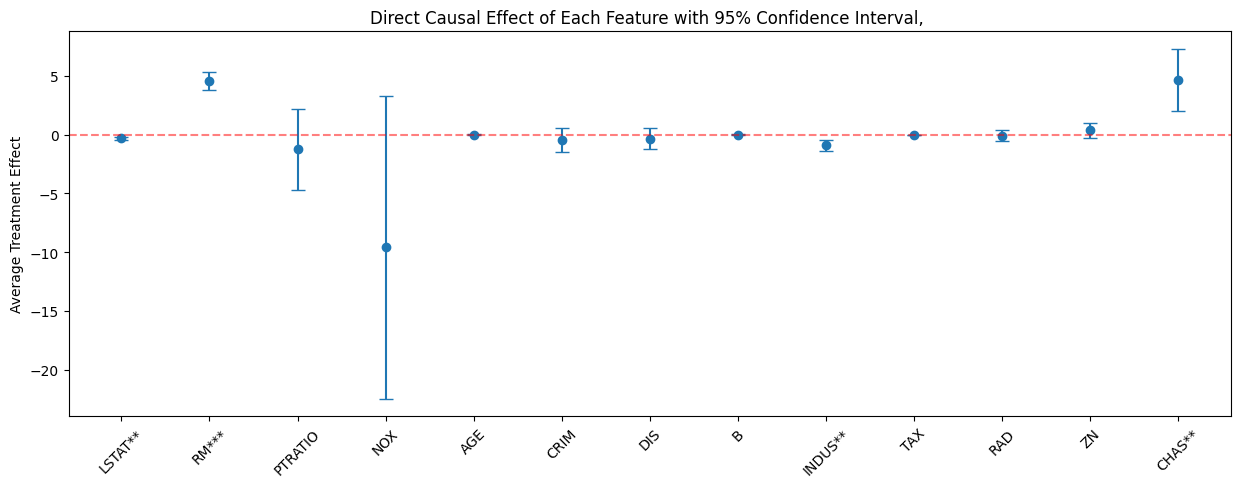

In [ ]:
errorbar(global_summ)

## Findings:  share of Black residents (B), we could see it also gives us **insignificant causal effect on housing price**, which means race by itself has no direct causal effect on home prices. By learning the correlation between B and other features, we could see it's highly correlated with crime rate(CRIM) and percentage of lower status population (LSTAT), which do have strong causal effects. This pattern of correlations make B as a strong predictor but not a direct driver. Using the causal analysis tool has helped us avoid reaching a controversial and incorrect conclusion.

## Segmentation -- How different type of houses respond differently to number of rooms?

##CATE: Conditional Average Treatment Effect - https://en.wikipedia.org/wiki/Average_treatment_effect

###  From the global level, we know that the ATE of RM is 4.5, which means in average adding one more room will raise the housing price by 4.5 units. In the shallow tree above, we could see although overall RM has a significant positive effect on housing price, housing price will be more expensive for one more room in regions with lower pupil-teacher rate, and the effect will be insignificant in the regions with higher pupil-teacher rate and lower retail business rate.

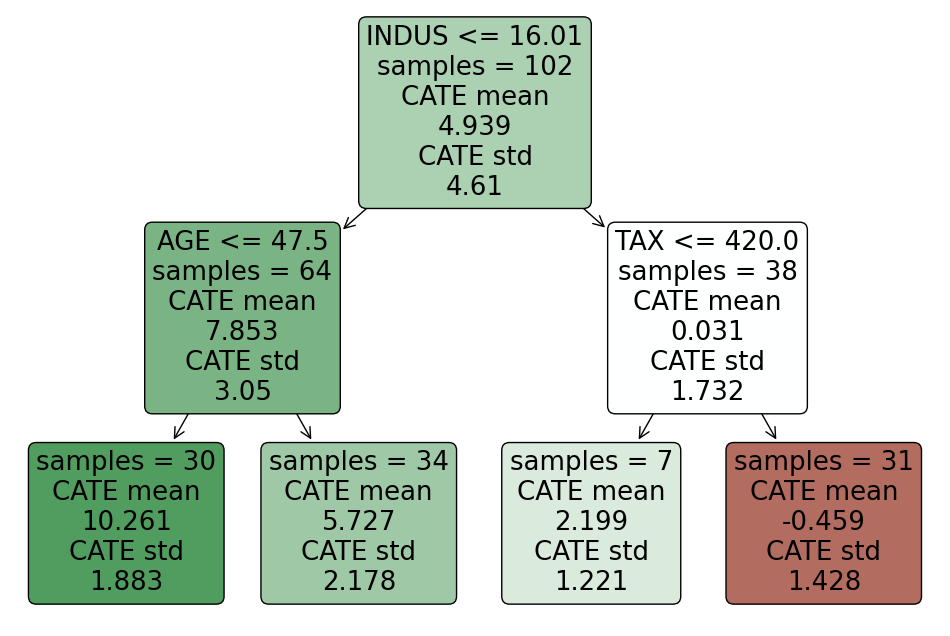

In [ ]:
plt.figure(figsize=(12, 8))


causal_analysis.plot_heterogeneity_tree(
    pd.DataFrame(x_test, columns=boston_data.feature_names),
    "RM",
    max_depth=2,
    min_impurity_decrease=1e-6,
)

## Policy Analysis -- What is the best policy considering cost?

### The recommended policy  (if followed), on average, the housing price will increase by 2 more units compared with no more room added. Similarly, it will increase by around 1.4 units compared with adding one more room for every house. To be more detailed, we could also output the individualized policy. In the following table, I will only print the top five houses ordered by policy gains.

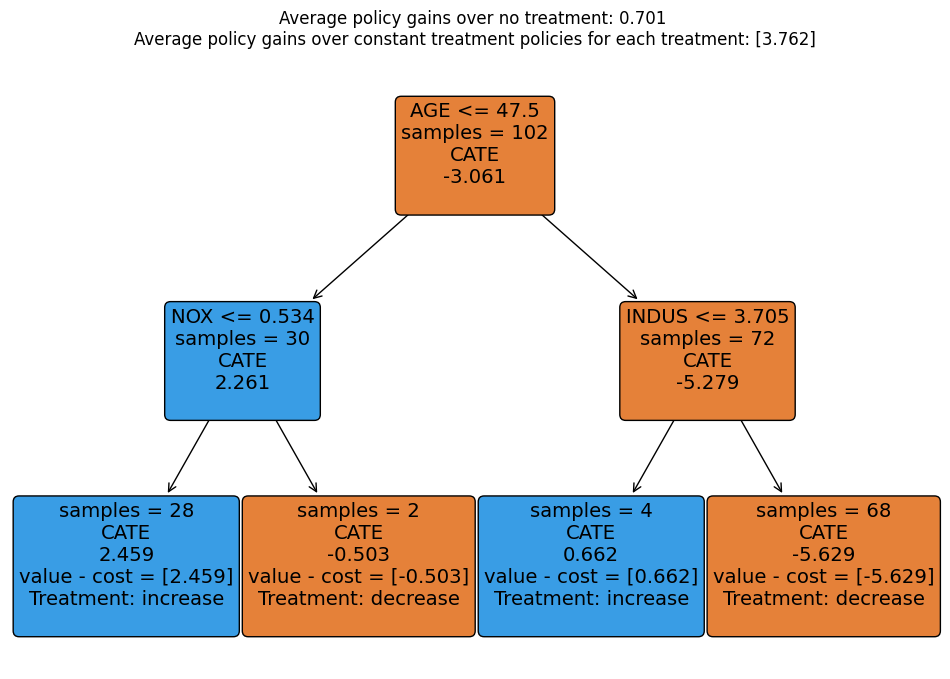

In [ ]:
plt.figure(figsize=(12, 8))

causal_analysis.plot_policy_tree(
    pd.DataFrame(x_test, columns=boston_data.feature_names),
    "RM",
    treatment_costs=8,
    max_depth=2,
)

## Note the effect of treatment is the treatment effect of increasing or decreasing 10% of average treatment level minus the cost, and decrease or increase mean in which direction we will get positive policy gain.

In [ ]:
causal_analysis.individualized_policy(
    pd.DataFrame(x_test, columns=boston_data.feature_names),
    "RM",
    n_rows=5,
    treatment_costs=4,
    alpha=0.1,
)

,Treatment,Effect of treatment,Effect of treatment lower bound,Effect of treatment upper bound,CRIM,ZN,INDUS,CHAS,NOX,Current treatment,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
363,decrease,6.143776,4.637519,7.650034,4.22239,0.0,18.1,1.0,0.770,5.803,89.0,1.9047,24.0,666.0,20.2,353.04,14.64
372,decrease,5.744509,4.476246,7.012773,8.26725,0.0,18.1,1.0,0.668,5.875,89.6,1.1296,24.0,666.0,20.2,347.88,8.88
374,decrease,5.071480,3.596144,6.546817,18.49820,0.0,18.1,0.0,0.668,4.138,100.0,1.1370,24.0,666.0,20.2,396.90,37.97
386,decrease,4.996036,3.948862,6.043210,24.39380,0.0,18.1,0.0,0.700,4.652,100.0,1.4672,24.0,666.0,20.2,396.90,28.28
400,decrease,4.935003,3.913544,5.956462,25.04610,0.0,18.1,0.0,0.693,5.987,100.0,1.5888,24.0,666.0,20.2,396.90,26.77


## What If Analysis - How the overall housing price changes with one more room?


In [ ]:
cf = causal_analysis.whatif(x_test, x_test['RM'] + 1, 5, y_test)

In [ ]:
print("Current average housing price on test set: ", y_test.mean())
print(
    "Average housing price with one more room on test set: ",
    cf["point_estimate"].mean(),
)

Current average housing price on test set:  22.21960784313725
Average housing price with one more room on test set:  27.158205882352938


###  Summary table: we could see overall if we add one more room in the test set, the housing price will increase by 4+ units, which is in line with the ATE we learnt above. And the histrogram shows a comparison between the current housing price distribution and the counterfactuals ditribution if we add one more room.

Text(0.5, 1.0, 'Histogram of Housing price -- Current vs. One more room')

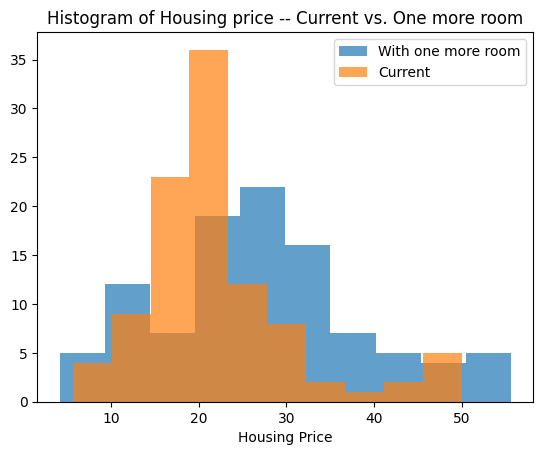

In [ ]:
# distribution comparison
plt.hist(cf.point_estimate, label="With one more room", alpha=0.7)
plt.hist(y_test, label="Current", alpha=0.7)
plt.legend()
plt.xlabel("Housing Price")
plt.title("Histogram of Housing price -- Current vs. One more room")

## Cohort Analysis -- What is the causal effect on a new dataset?


In [ ]:
# global effect on new dataset
causal_analysis.cohort_causal_effect(x_test)

,,point,stderr,zstat,p_value,ci_lower,ci_upper
feature,feature_value,,,,,,
LSTAT,num,-0.244168,0.070479,-3.464419,5.313784e-04,-0.382304,-0.106032
RM,num,4.938607,0.458444,10.772544,4.639989e-27,4.040073,5.837140
PTRATIO,num,-0.527746,2.398316,-0.220048,8.258335e-01,-5.228359,4.172868
NOX,num,-11.774538,7.120638,-1.653579,9.821304e-02,-25.730731,2.181655
AGE,num,0.005365,0.022245,0.241173,8.094214e-01,-0.038235,0.048965
CRIM,num,-0.380633,0.516337,-0.737179,4.610135e-01,-1.392635,0.631369
DIS,num,-0.124171,0.426574,-0.291088,7.709838e-01,-0.960240,0.711898
B,num,0.006946,0.006403,1.084699,2.780550e-01,-0.005605,0.019496
INDUS,num,-1.128744,0.253605,-4.450788,8.555564e-06,-1.625802,-0.631687


In [ ]:
# local effect on new dataset
causal_analysis.local_causal_effect(x_test)

point     stderr     zstat       p_value  \
sample feature feature_value                                                 
0      LSTAT   num             0.264491   0.186106  1.421184  1.552632e-01   
       RM      num            13.173663   2.025169  6.504969  7.770948e-11   
       PTRATIO num             0.483544   1.113003  0.434450  6.639617e-01   
       NOX     num           -13.635682  28.305098 -0.481739  6.299911e-01   
       AGE     num            -0.022339   0.045317 -0.492943  6.220525e-01   
...                                 ...        ...       ...           ...   
101    INDUS   num            -0.352295   0.267868 -1.315178  1.884500e-01   
       TAX     num            -0.011294   0.025159 -0.448913  6.534941e-01   
       RAD     num            -0.173270   0.669988 -0.258617  7.959309e-01   
       ZN      num            -0.051377   0.084189 -0.610262  5.416882e-01   
       CHAS    1.0v0.0         4.172710   3.903192  1.069051  2.850469e-01   

                               ci_lower   ci_upper  
sample feature feature_value                        
0      LSTAT   num            -0.100270   0.629253  
       RM      num             9.204404  17.142922  
       PTRATIO num            -1.697902   2.664990  
       NOX     num           -69.112654  41.841290  
       AGE     num            -0.111158   0.066481  
...                                 ...        ...  
101    INDUS   num            -0.877307   0.172718  
       TAX     num            -0.060604   0.038016  
       RAD     num            -1.486423   1.139882  
       ZN      num            -0.216384   0.113630  
       CHAS    1.0v0.0        -3.477406  11.822825  

[1326 rows x 6 columns]

#END WORKSHOP